# Learning from data 2018 - Project 2

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|13th March 2018  | **12:00 Thursday 29th March 2018** |


This workshop is worth 10% of the total module mark.

Candidate number: ** 650046686 **  

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations, if any), what the results mean, how they relate to the theory, etc.

You can add new cells as you think fit and delete ones that are not needed (do not delete this preamble). 

### Submitting the notebooks

Only an electronic submissions is required.  Submit your notebook (the .ipynb file) to electronic copy via the  [electronic hand-in system](http://empslocal.ex.ac.uk/submit/) using the topic <cmd>2018-03-29~ECM3420~Lorenzo Livi~Project-2-ESN</cmd>.

You should be able to upload the notebook directly from wherever it is on your machine.  If you're not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out.  To keep the marking anonymous, please don't leave directory names that reveal your identity in cells.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 

## Project specification

The project consists of two parts, each one worth 5% of the total 10% associated with this assessed workshop.
<ol>
  <p>**First part of the project**</p>
  <li>Implement a standard echo state network (ESN) model. Do not include feedback from the output and do not include leaking neurons. Implement training of the read-out by solving a standard regularized least-square problem. Perform some preliminary simulations by considering a *k*-step ahead forecasting task (evaluate several values of *k* as forecasting horizon) on the "2sine" time series and describe the experimental results.</li>
    <p>**Second part of the project**</p>
  <li>Implement a version of the ESN model that is trained online by means of the least-mean-square algorithm. Perform simulations to compare the performance on a *k*-step ahead forecasting task with respect to the standard ESN implementation (first part of the project). In the experiments, take into account multiple *k* values for the forecasting horizon (i.e., explore the effects of increasing *k* on the performance) and process the "2sine" and "lorenz" time series provided in the archive.</li>
</ol>

<font color='blue'>**All of my comments in markdown cells below are written in blue to make my comments clear and stand out from the original instruction text.**<br>
Note: Although I believe I have implemented many parts of the workshop correctly in python, some did not yield the expected results. However, I wanted to prove that I had dedicated a great deal of time and that I am knowledgeable about the topics discussed in this workshop, which I hope you find is demonstrated by my discussion and analysis section of the workshop which was based on my own findings together with external research.
</font>


### Part 1 of the project...

Populating the interactive namespace from numpy and matplotlib


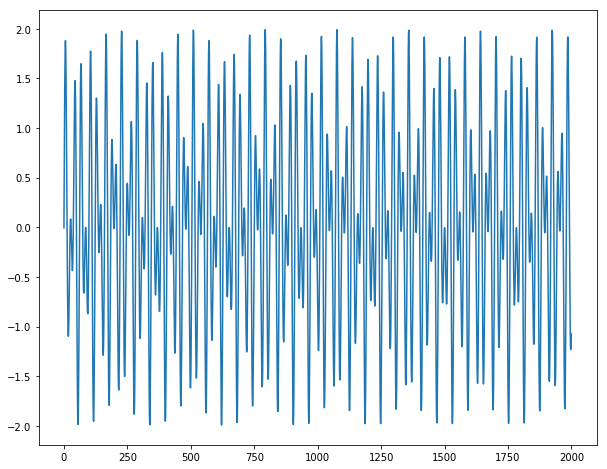

In [103]:
# make sure plots are displayed correctly on notebooks
%matplotlib inline
% pylab inline
import wget
figsize(10, 8)

from __future__ import print_function
import sys
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils import check_array
from numpy import zeros, ones, concatenate, array, tanh, vstack, arange
import numpy as np
import scipy.linalg as la

"""
    ESN implements a standard echo state network model that implements training of the readout
    by solbinh a standard regularized least0square problem.
    Parameters:
    X : a training data set
    Xtest : a testing data set
    n_readout : The number of readout neurons. This integer is
        chosen at random in the reservoir, and defines the
        dimension of the ESN output results. Chose to include this
        for flexibility in testing.
"""

def ESN(X, Xtest, numReadout):
    
    numNeurons = 100
    # I included leak rate of neurons in model (although not required) for when I
    # want to experiment around with leaking neurons - however, hardcoded to 1
    # for this exercise as specified by the requirements of no leaking neurons.
    leakRate = 1 # Kept leak rate for own curiosity
    # scalar for weights (recurrent layer) chosen value close to 1
    scalarWeightsR = 0.9
    
    # get size of data set and dimension
    numData, dim = X.shape

    # ensure 2d
    X = check_array(X, ensure_2d=True)
    
    # get random weightR
    weightsR = np.random.randn(numNeurons, numNeurons)-0.5
    
    # get spectral radius
    spectralRadius = np.max(np.abs(la.eig(weightsR)[0]))
    
    # multiple weightsR (reasons discussed to full length in markdown below)
    weightsR *= scalarWeightsR / spectralRadius
    
    # random weightsInput
    weightsInput = np.random.randn(numNeurons, 1+dim)-0.5
    
    # define my readout index (included for numReadout as defined in method documentation)
    readoutIndex = np.random.permutation(arange(1+dim, 1+dim+numNeurons))[:numReadout]

    # defined vector to hold resulting values
    components = zeros(shape=(1+dim+numNeurons, numData))
    current = zeros(shape=(numNeurons, 1))
    on = concatenate((ones(shape=(numData, 1)), X), axis=1)

    # get components by  
    for t in range(numData):
        u = array(on[t,:], ndmin=2).T
        current = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
        components[:,t] = vstack((u, current))[:,0]
    components = components.T
    
    regPar = 1e-5  # chose appropriate regularization coefficient

    # get identity matrix
    I = np.identity(components.shape[1])
    
    # get Wo based on defined formula (transpose for later training Zo)
    Wo = dot(linalg.inv(dot(components.T, components) + dot(regPar**2, I)), dot(components.T, data)).T
    
    # train data base on Wo
    components2 = zeros(shape=(1+dim+numNeurons, numData))
    on2 = concatenate((ones(shape=(numData, 1)), X), axis=1)
    
    # training read out using the regularized least square problem (Zo = (Wo.T)(xt) formula ) 
    for t in range(numData):
        u = array(on[t,:], ndmin=2).T
        current = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
        sh = vstack((u, current))[:,0].shape[0]
        c = Wo.dot(vstack((u, current))[:,0].reshape(sh,1))
        components2[:,t] = c

    # return components
    return components2[readoutIndex].T

data = np.loadtxt("2sin")
data = data.reshape(-1, 1)
h = math.ceil(len(data)/2)
X = data[:]
Xtest = data[h:]
r = ESN(X, Xtest, 1)
plot(r)

<font color = "blue" size="3">
Discussion of my model and forecast with ESN results:
<br><br>
An ESN model, as I have implemented above, can be though of in 3 components:
    (1) the input layer,
    (2) the recurrent reservoir,
    (3) and at last a readout.
<br><br>
The observed output of an Echo State Network is calculated namely by completing two steps. That is, first we define an $N_{i}$-dimensional input vector that is made for the recurrent reservoir. The $W^{r}$ weight matrix for recurrent layer are such that its size is the number of neurons in the recurrent layer. The $W^{i}$ is the input-to-recurrent layer matrix. The elements of $W^{i}$ are independently drawn from a uniform
distribution in [−1, 1], but $W^{r}$ directly affect the dynamics of the network and therefore a lot of attention must be paid to these weights (as we can see in the code above, but we will also discuss in the next paragraph). However, all elements are randomly instantiated at the start of the learning, and remain unaltered.
<br><br>
As mentioned, the matrix $W^{r}$ requires a bit more attention. In accordance to the ESN theory, the reservoir
must follow the "echo state property", which suggests that the impact of certain data on the state of the reservoir must dissapear in a finite amount of time-instants. A suggested method to satisfy this requirements is to rescale the matrix $W^{r}$ to have a spectral radius operator < 1. What does this mean? Well when the requirements of the echo state propery are met, an Echo State Network with a sufficiently big reservoir can estimate all non-linear filters with bounded memory to any desired accuracy.
<br><br>
To establish the weight matrices in the readout, we defined a sequence of D desired input-outputs pairs such that:<br>
(z[1], y[1]) . . . , (z[D], y[D]).
<br><br>
According to the above, we may also state that:<br>
y[t] = z[t + f],
<br><br>
where f determines the forecast horizon. In state harvesting, which are the first stages of training, the inputs are given to the reservoir, which generates a sequence of internal states. The outputs of Echo State Network are not available for feedback, so they are replaced with the desirable output, which is called teacher forcing. The
desirable outputs are stored in a vector (d), the resulting states are stacked inside a matrix.

This training problem can be defined as a standard linear regression, for which, in this workshop, we use the least-square regression.

</font>


In [104]:
def forecast(X, Xtest, numReadout, kRange):
    
    numNeurons = 100
    # I included leak rate of neurons in model (although not required) for when I
    # want to experiment around with leaking neurons - however, hardcoded to 1
    # for this exercise as specified by the requirements of no leaking neurons.
    leakRate = 1 # Kept leak rate for own curiosity
    # scalar for weights (recurrent layer) chosen value close to 1
    scalarWeightsR = 0.9
    
    # get size of data set and dimension
    numData, dim = X.shape

    # ensure 2d
    X = check_array(X, ensure_2d=True)
    
    # get random weightR
    weightsR = np.random.randn(numNeurons, numNeurons)-0.5
    
    # get spectral radius
    spectralRadius = np.max(np.abs(la.eig(weightsR)[0]))
    
    # multiple weightsR (reasons discussed to full length in markdown below)
    weightsR *= scalarWeightsR / spectralRadius
    
    # random weightsInput
    weightsInput = np.random.randn(numNeurons, 1+dim)-0.5
    
    # define my readout index (included for numReadout as defined in method documentation)
    readoutIndex = np.random.permutation(arange(1+dim, 1+dim+numNeurons))[:numReadout]

    # defined vector to hold resulting values
    components = zeros(shape=(1+dim+numNeurons, numData))
    current = zeros(shape=(numNeurons, 1))
    on = concatenate((ones(shape=(numData, 1)), X), axis=1)

    # get components by  
    for t in range(numData):
        u = array(on[t,:], ndmin=2).T
        current = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
        components[:,t] = vstack((u, current))[:,0]
    components = components.T
    
    regPar = 1e-5  # chose appropriate regularization coefficient

    # get identity matrix
    I = np.identity(components.shape[1])
    
    # get Wo based on defined formula (transpose for later training Zo)
    Wo = dot(linalg.inv(dot(components.T, components) + dot(regPar**2, I)), dot(components.T, data)).T

    errors = []
    for k in range(kRange):
        # train data base on Wo
        components2 = zeros(shape=(1+dim+numNeurons, numData))
        on2 = concatenate((ones(shape=(numData, 1)), X), axis=1)
        componentsPredicted = zeros(shape=(1+dim+numNeurons, numData))
        k = 2
        # training read out using the regularized least square problem (Zo = (Wo.T)(xt) formula ) 
        for t in range(numData):
            u = array(on[t,:], ndmin=2).T
            current = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
            sh = vstack((u, current))[:,0].shape[0]
            c = Wo.dot(vstack((u, current))[:,0].reshape(sh,1))
            components2[:,t] = c
            # the predicted would have been made here
            if (t+k < numData-1):
                u = array(on[t+k,:], ndmin=2).T
                currentPred = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
                sh = vstack((u, currentPred))[:,0].shape[0]
                c = Wo.dot(vstack((u, currentPred))[:,0].reshape(sh,1))
                componentsPredicted[:,t+k] = c
        print(componentsPredicted)
        print(components2)
        errors.append(abs(componentsPredicted[0][k]-components2[0][t+k]))

    return components2[readoutIndex].T
    
#l = forecast(X, Xtest, 1, 30)


<font color = "blue" size="3">Note: I have used my ESN function and altered it to investigate how to implement k-step ahead forecasting task. I have not combined both requirements into one function at last as to keep oversight over the functionality, since I am not entirely sure that I was able properly implement preliminary simulations by considering a *k*-step ahead forecasting task. Although, I do believe that I was on a track to a working functions, and hope that the discussion and findings that will be fully detailed in markdown below will shine light on the reasearch and the time that I have dedicated to this workshop.
<br><br>

<b>Implementation and Analysis: </b><br><br>
Works referred to: Bianchi's "Short-term
electric load forecasting using echo state networks and PCA decomposition" (cited in Echo State Network lecture slides).<br><br>

Considering a K-step ahead prediction problem, in an Echo State Network for each component X(t) we can expect a predicted value X'(t + k). If I were able to implement the theory correctly in code, I would adopt the error  measurement known as the Normalized Root Mean Squared Error function, which is commonly used function to measure error that signifies the standard deviation of the differences between observed and predicted values (Bianchi).<br><br>
The difference in functionality of the forecast() function to the ESN() is in the second for loops. It is certain that k value will be used to predict future component values and we must find the difference between those and the actual results. I constructed the function in such way as to test a range of k values, to see how far we can predict without excessive error. Although I have not been able to get my code running, given more time I am certain of the the optimization procedure that should occur. Essentially, we would evaluate the "fitness" of the genetic code by obtaining the forecast accuracy, which would be derived from a validation set X that is  made by splitting the training data in two. The first dataset will be the new training dataset and what is left will be the validation set.<br><br>
Thereafter, each genetic code $c_{p}$ determines a network $ESN_{p}$ and we use a "teacher" signal and input for training the readout, much like in the ESN() function. The important part is the next step, which is to sequentially at each time interval t we present the same values as input to $ESN_{p}$ and we observe the true values in comparison to the the predicted values. Here, the "fitness" of the genetic
code $c_{p}$ is determined based on the prediction error. Hence, once we compute the
optimal genetic code $c_{optimal}$, the related $ESN_{optimal}$ can be utilised for forecasting of values of the test data. At last, we can derive the generalization capability of the system by observing the the prediction error on the test dataset.<br><br>
The expected results could be as follows: we would observe that the best prediction accuracy
is made during a 1-step ahead forecast; that is, naturally because of its simplicity, we can calculate it effectively on the original values. On the other hand, if we were to discuss a longer time-intervals ahead, we could expect the resulting forecast accuracy to decreases significantly. Although I do not have a plot of this in the workshop, from reading about this in existing research and making informed predictions, it can most certainly be concluded that ideal scenarios of the ESN model are those with 1-step ahead predictions. To aid this conclusion, I will paraphrase Bianchi's work, which states that the "hyperbolic tangent transfer functions" of the neurons found in the reservoir have the ability to "map an input signal in a high dimensional nonlinear
space". Therefore, I can deduce that methods based on a ESN model, such those in this workshop, have the desirable capability to learn from nonlinear relationships to be able to yield high accuracy of predicted results, especially if the relationships are properly trained on suitable preprocessed data. We would therefore observe that the the ESN will be especially effective in short term predictions, and reducing the problem to k 1-step ahead predictions would create a very desirable application scenario of the ESN model. 
<br><br>
With regards to prediction of future values, we may always leverage previously observed history. Being able to attain this for the ESN model means that a forecast method could significantly reduce cost of computation and keep it efficient. However, we could also expect that wrong predictions can mean either a "load underestimation", which, in real life situations, can cause shortcomings in achieving enough provisions which results in higher costs in supplementary services, or a "load overestimation", which could results in an excess of supplies and therefore be more costly as well.

</font>

### Part 2 of the project...

In [102]:
def onlineESN(X, Xtest, numReadout):
    
    numNeurons = 100
    # I included leak rate of neurons in model (although not required) for when I
    # want to experiment around with leaking neurons - however, hardcoded to 1
    # for this exercise as specified by the requirements of no leaking neurons.
    leakRate = 1 # Kept leak rate for own curiosity
    # scalar for weights (recurrent layer) chosen value close to 1
    scalarWeightsR = 0.9
    
    # get size of data set and dimension
    numData, dim = X.shape

    # ensure 2d
    X = check_array(X, ensure_2d=True)
    
    # get random weightR
    weightsR = np.random.randn(numNeurons, numNeurons)-0.5
    
    # get spectral radius
    spectralRadius = np.max(np.abs(la.eig(weightsR)[0]))
    
    # multiple weightsR (reasons discussed to full length in markdown below)
    weightsR *= scalarWeightsR / spectralRadius
    
    # random weightsInput
    weightsInput = np.random.randn(numNeurons, 1+dim)-0.5
    
    # define my readout index (included for numReadout as defined in method documentation)
    readoutIndex = np.random.permutation(arange(1+dim, 1+dim+numNeurons))[:numReadout]

    # defined vector to hold resulting values
    components = zeros(shape=(1+dim+numNeurons, numData))
    current = zeros(shape=(numNeurons, 1))
    on = concatenate((ones(shape=(numData, 1)), X), axis=1)

    # get components by  
    for t in range(numData):
        u = array(on[t,:], ndmin=2).T
        current = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
        components[:,t] = vstack((u, current))[:,0]
    components = components.T
    
    regPar = 1e-5  # chose appropriate regularization coefficient

    # get identity matrix
    I = np.identity(components.shape[1])
    
    # get Wo based on defined formula (transpose for later training Zo)
    Wo = dot(linalg.inv(dot(components.T, components) + dot(regPar**2, I)), dot(components.T, data)).T
    
    # train data base on Wo
    components2 = zeros(shape=(1+dim+numNeurons, numData))
    on2 = concatenate((ones(shape=(numData, 1)), X), axis=1)
    learningRate = 0.8
    
    # training read out using the regularized least square problem (Zo = (Wo.T)(xt) formula ) 
    for t in range(numData):
        u = array(on[t,:], ndmin=2).T
        current = (1-leakRate)*current + leakRate*tanh(weightsInput.dot(u) + weightsR.dot(current))
        sh = vstack((u, current))[:,0].shape[0]
        c = Wo.dot(vstack((u, current))[:,0].reshape(sh,1))
        # define necessary variables for online learning
        dk = np.ones(Wo.shape)
        e = dk - c.dot(Wo)
        Wo = Wo + learningRate*c.dot(e)
        components2[:,t] = c

    # return trained data
    return components2[readoutIndex].T

l = np.loadtxt("lorenz")
l = data.reshape(-1, 1)
h2 = math.ceil(len(l)/2)
X2 = l[:]
Xtest2 = l[h2:]
res = onlineESN(X, Xtest, 1)


<font color = "blue" size="3">
<b>Discussion:</b>

The ESN model allows for online learning, such that it processes each distinct element in training seperately.
By implementing the online machine learning, we make data available in a sequential order, which allows us to update the best predictor for future data at each distinct step. Althought online algorithms can be expected to perform faster, it is not always certain that online learning yields results that are as accurate as those generated with batch learning results. Therefore, there remains an important decision when chosing a learning technique. 
<br><br>
From interpreting the pseudocode and the theory of the online learning technique I am able to deduct that chosing online learning may always depend on the problem at hand, despite its performance. While batch learning method learns on an entire training dataset in one go in order to determine the best predictor, online learning is a very desirable technique for machine learning problems where it is computationally inprobable to train over the whole dataset (and as a result could require out-of-core algorithms). Additionally, for problems where data is created as a function of time (such as stock price predictions) or it is necessary for the algorithm to adapt to new patterns dynamically, online learning would be most suitable.
</font>